<a href="https://colab.research.google.com/github/kul-pat/Public-Machine-learning/blob/main/Diabeteses_using_NN_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df['Glucose']=np.where(df['Glucose']==0,df['Glucose'].median(),df['Glucose'])
df['Insulin']=np.where(df['Insulin']==0,df['Insulin'].median(),df['Insulin'])
df['SkinThickness']=np.where(df['SkinThickness']==0,df['SkinThickness'].median(),df['SkinThickness'])
df['BloodPressure']=np.where(df['BloodPressure']==0,df['BloodPressure'].median(),df['BloodPressure'])
df['BMI']=np.where(df['BMI']==0,df['BMI'].median(),df['BMI'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,30.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,30.5,26.6,0.351,31,0
2,8,183.0,64.0,23.0,30.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

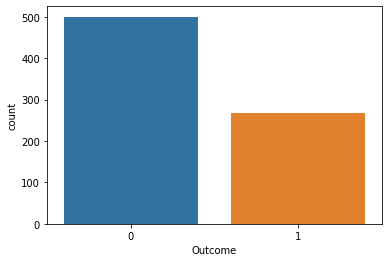

In [ ]:
sns.countplot(x='Outcome',data=df)

In [ ]:
X= df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print(type(X_train))

<class 'numpy.ndarray'>


In [ ]:
#scaler = StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

In [ ]:
Epochs = 1000
Batch_size = 50
Learnig_rate = 0.001

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
 ## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 8.
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=Learnig_rate)

BinaryClassification(
  (layer_1): Linear(in_features=8, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, Epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.68162 | Acc: 56.077
Epoch 002: | Loss: 0.55287 | Acc: 68.846
Epoch 003: | Loss: 0.53648 | Acc: 72.385
Epoch 004: | Loss: 0.51545 | Acc: 74.846
Epoch 005: | Loss: 0.49967 | Acc: 75.154
Epoch 006: | Loss: 0.51435 | Acc: 73.077
Epoch 007: | Loss: 0.48708 | Acc: 74.923
Epoch 008: | Loss: 0.48760 | Acc: 77.462
Epoch 009: | Loss: 0.48591 | Acc: 77.692
Epoch 010: | Loss: 0.46190 | Acc: 77.154
Epoch 011: | Loss: 0.46822 | Acc: 77.692
Epoch 012: | Loss: 0.48518 | Acc: 76.615
Epoch 013: | Loss: 0.47160 | Acc: 77.615
Epoch 014: | Loss: 0.46477 | Acc: 76.923
Epoch 015: | Loss: 0.45943 | Acc: 77.538
Epoch 016: | Loss: 0.44329 | Acc: 77.615
Epoch 017: | Loss: 0.45554 | Acc: 77.000
Epoch 018: | Loss: 0.44957 | Acc: 77.923
Epoch 019: | Loss: 0.44482 | Acc: 79.769
Epoch 020: | Loss: 0.44303 | Acc: 78.077
Epoch 021: | Loss: 0.45081 | Acc: 77.615
Epoch 022: | Loss: 0.44879 | Acc: 78.692
Epoch 023: | Loss: 0.42444 | Acc: 78.692
Epoch 024: | Loss: 0.45848 | Acc: 78.538
Epoch 025: | Los

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[88, 19],
       [17, 30]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       107
           1       0.61      0.64      0.62        47

    accuracy                           0.77       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.77      0.77      0.77       154

